In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qiskit

2023-06-07 13:15:15.676841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


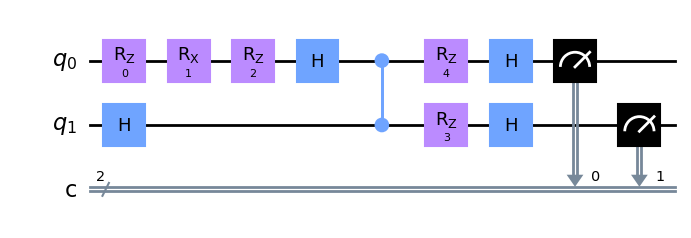

In [2]:
dev = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev)
def circuit(x):
    qml.Hadamard(wires=1)
    qml.RZ(0,wires=0)
    qml.RX(1,wires=0)
    qml.RZ(2,wires=0)
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(3,wires=1)
    qml.RZ(4,wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)   
    return qml.expval(qml.PauliZ(0))

circuit([0,1,2,3,4])

dev._circuit.draw(output='mpl')

In [3]:
dev1 = qml.device('default.mixed', wires=2)

In [4]:
def real():
    qml.Hadamard(wires=1) 

In [5]:
def generator(w,**kwargs):
    qml.RZ(w[0],wires=0)
    qml.RX(w[1],wires=0)
    qml.RZ(w[2],wires=0)
    qml.BitFlip(p,wires=0)

In [6]:
def discriminator(w,**kwargs):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0],wires=1)
    qml.RZ(w[1],wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)
    qml.BitFlip(p,wires=0)
    qml.BitFlip(p,wires=1)

In [7]:
@qml.qnode(dev1, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))

In [8]:
p = 0.1
print(qml.draw(real_gen_disc_circuit)([ 0,0,0],[ 0,0]))

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)──BitFlip(0.10)──H─╭Z──RZ(0.00)──H──BitFlip(0.10)─┤ ╭<𝓗>
1: ──H──────────────────────────────────────────────╰●──RZ(0.00)──H──BitFlip(0.10)─┤ ╰<𝓗>


In [9]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [10]:
@qml.qnode(dev1, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev1, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [11]:
def disc_cost(disc_weights):
    cost =1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [13]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))
    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

# train only generator while discriminator is a perfect swap frozen discriminator
loss_val_d = []
loss_val_g = []
step_d = []
step_gf = []
sg_f =[]
epochs = 6
for i in range(epochs):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    a = 40
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf            

Step 0: cost = 0.2499447684310002
Step 5: cost = 0.24917864851691954
Step 10: cost = 0.24739495824043262
Step 15: cost = 0.24441336477073186
Step 20: cost = 0.2400724017953208
Step 25: cost = 0.23425120816624717
Step 30: cost = 0.22688766207590716
Step 35: cost = 0.21799195318611647
Step 40: cost = 0.20821570417878973
Step 45: cost = 0.1997914383499047
Step 50: cost = 0.19081029643299316
Step 55: cost = 0.18132874225732346
Step 60: cost = 0.17142648149242193
Step 65: cost = 0.16120892655841318
Step 70: cost = 0.15080586058589301
Step 75: cost = 0.14036668430863772
Step 80: cost = 0.13013383516425184
Step 85: cost = 0.12045532622130739
Step 90: cost = 0.11110162685081101
Step 95: cost = 0.10219747021081962
Step 100: cost = 0.09386413304768332
Step 105: cost = 0.08621043193295291
Step 110: cost = 0.07932381325099058
Step 115: cost = 0.07326302533244788
Step 120: cost = 0.06787000937040738
Step 125: cost = 0.06260955935678614
Step 130: cost = 0.058299531663520004
Step 135: cost = 0.054991

In [ ]:
#step_g

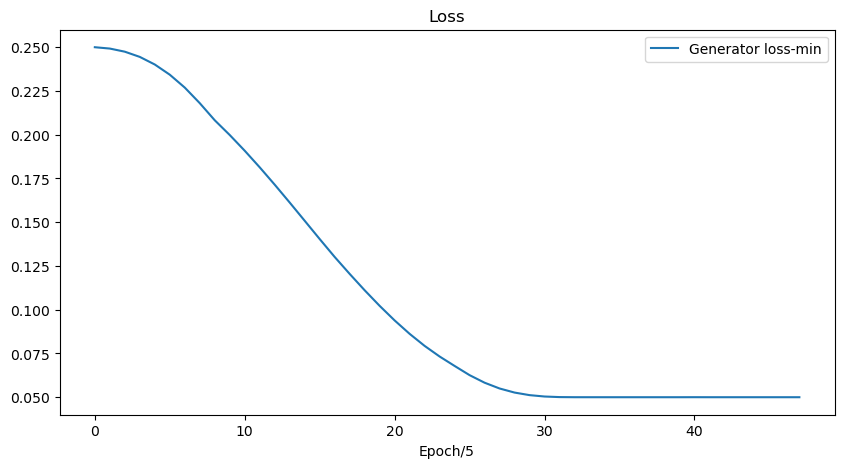

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

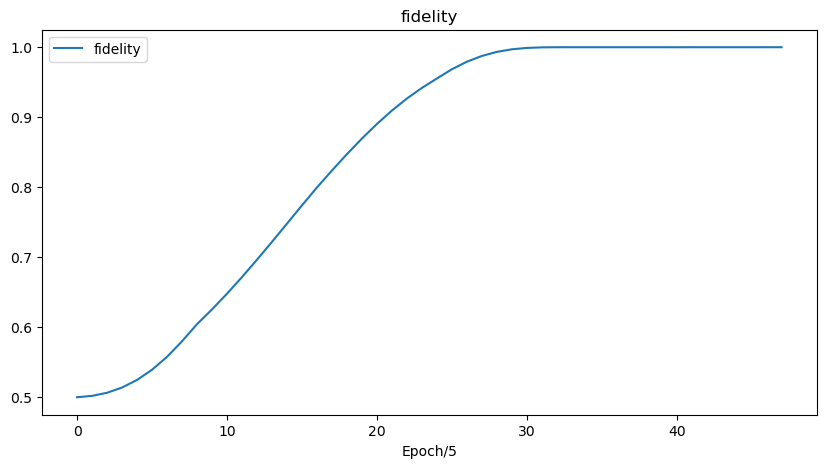

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

In [ ]:
range(len(step_g))

In [ ]:
len(perfect_swap)

In [ ]:
len(perfect_step_g)

In [16]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 3
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    a1 = 50
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 15
a2 = 6
a3 = 6
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.2499447684310002
Step 5: cost = 0.24917864851691954
Step 10: cost = 0.24739495824043262
Step 15: cost = 0.24441336477073186
Step 20: cost = 0.2400724017953208
Step 25: cost = 0.23425120816624717
Step 30: cost = 0.22688766207590716
Step 35: cost = 0.21799195318611647
Step 40: cost = 0.2076542017707117
Step 45: cost = 0.1960452052143801
Step 50: cost = 0.18413232510799082
Step 55: cost = 0.17456876455518464
Step 60: cost = 0.16472981861766203
Step 65: cost = 0.1547067777063159
Step 70: cost = 0.1446094725824461
Step 75: cost = 0.13456406288182116
Step 80: cost = 0.12470780933001924
Step 85: cost = 0.11518165291683374
Step 90: cost = 0.10612165276182031
Step 95: cost = 0.0976503852027481
Step 100: cost = 0.08975808131389529
Step 105: cost = 0.08210898149336865
Step 110: cost = 0.07520496366726098
Step 115: cost = 0.0691520464250579
Step 120: cost = 0.0640209703518414
Step 125: cost = 0.05983598878361149
Step 130: cost = 0.056569471382792724
Step 135: cost = 0.054144194906

In [ ]:
#step_g

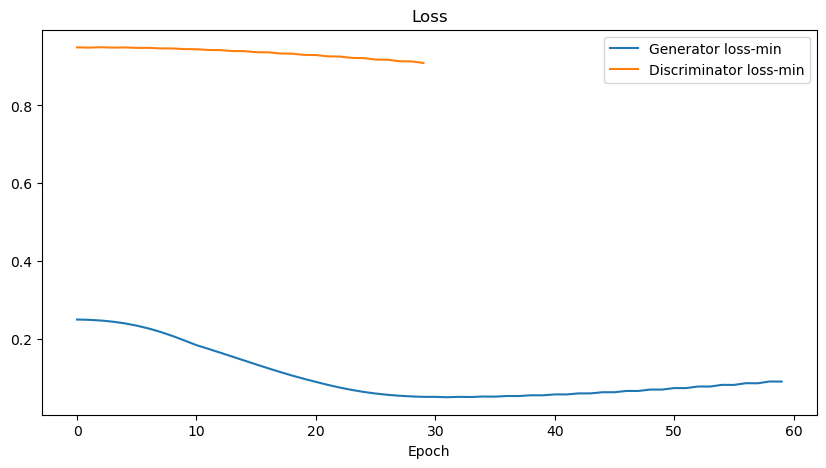

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

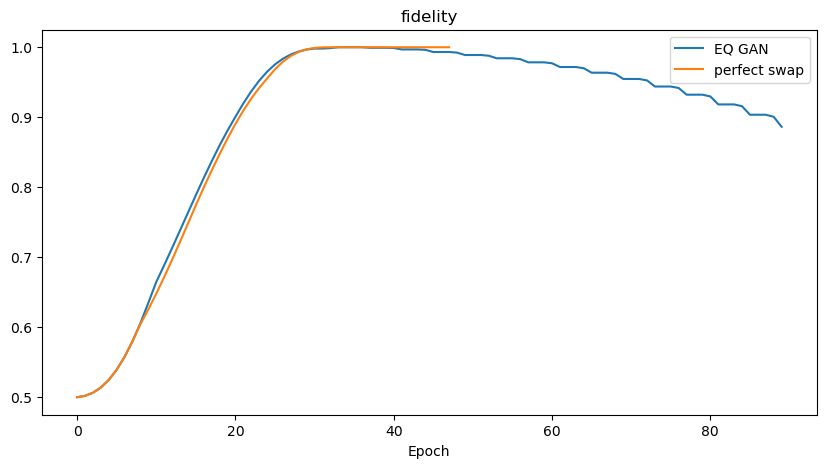

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [20]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 2
a1 = 40
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 8
a2 = 2
a3 = 2
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.2499447684310002
Step 5: cost = 0.24917864851691954
Step 10: cost = 0.24739495824043262
Step 15: cost = 0.24441336477073186
Step 20: cost = 0.2400724017953208
Step 25: cost = 0.23425120816624717
Step 30: cost = 0.22688766207590716
Step 35: cost = 0.21799195318611647
Step 40: cost = 0.20821570417878973
Step 45: cost = 0.1997914383499047
Step 50: cost = 0.19081029643299316
Step 55: cost = 0.18132874225732346
Step 60: cost = 0.17142648149242193
Step 65: cost = 0.16120892655841318
Step 70: cost = 0.15080586058589301
Step 75: cost = 0.14036668430863772
Step 80: cost = 0.8672685830033493
Step 82: cost = 0.13142075098750583
Step 84: cost = 0.8698574923116308
Step 86: cost = 0.128894515472595
Step 88: cost = 0.8723235930368973
Step 90: cost = 0.12648825138715428
Step 92: cost = 0.8746707632575998
Step 94: cost = 0.1241996252117949
Step 96: cost = 0.8769014999705063
Step 98: cost = 0.12202613665963907
Step 100: cost = 0.8790183982781199
Step 102: cost = 0.11996513303661968
Step

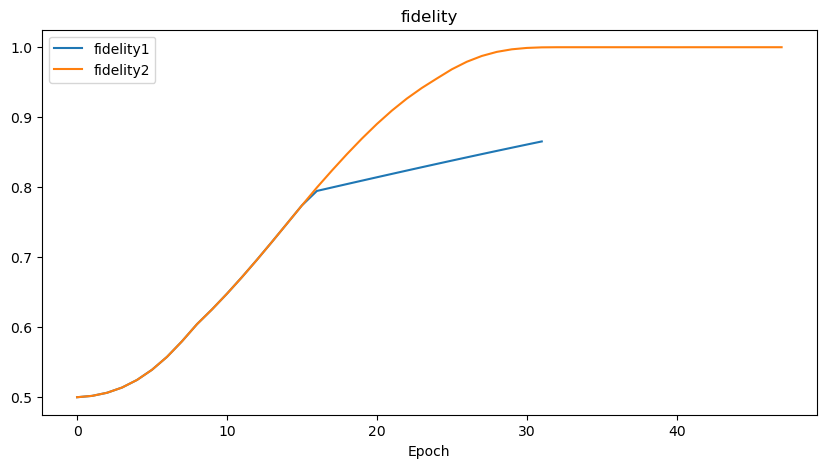

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="fidelity1")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="fidelity2")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()